Loan prediction contest on Analytics Vidhya.

In [694]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
pd.options.mode.chained_assignment = None 
plt.style.use('ggplot')

In [695]:
# Read data
train_set = pd.read_csv('train.csv')
test_X = pd.read_csv('test.csv')
train_set.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [696]:
# Prepare the train and test set
train_set.pop('Loan_ID')
train, valid = train_test_split(train_set, test_size=0.1, random_state=42)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
train_Y = train.pop('Loan_Status')
valid_Y = valid.pop('Loan_Status')
train_X , valid_X = train, valid
loan_id = test_X.pop('Loan_ID')
print('train_X =', train_X.shape)
print('train_Y =', train_Y.shape)
print('valid_X =', valid_X.shape)
print('valid_Y =', valid_Y.shape)
print('test_X =', test_X.shape)

train_X = (552, 11)
train_Y = (552,)
valid_X = (62, 11)
valid_Y = (62,)
test_X = (367, 11)


In [697]:
# Convert all values to numerical values
# One-hot encoding
train_X = pd.get_dummies(train_X, columns=["Gender","Married"], drop_first=False)
test_X = pd.get_dummies(test_X, columns=["Gender","Married"], drop_first=False)
valid_X = pd.get_dummies(valid_X, columns=["Gender","Married"], drop_first=False)

#Frequency encoding
pa = train_X.groupby('Property_Area').size()/len(train_X)
edu = train_X.groupby('Education').size()/len(train_X)
emp = train_X.groupby('Self_Employed').size()/len(train_X)

train_X['Property_Area'] = train_X['Property_Area'].map(pa)
train_X['Education'] = train_X['Education'].map(edu)
train_X['Self_Employed'] = train_X['Self_Employed'].map(emp)

valid_X['Property_Area'] = valid_X['Property_Area'].map(pa)
valid_X['Education'] = valid_X['Education'].map(edu)
valid_X['Self_Employed'] = valid_X['Self_Employed'].map(emp)

test_X['Property_Area'] = test_X['Property_Area'].map(pa)
test_X['Education'] = test_X['Education'].map(edu)
test_X['Self_Employed'] = test_X['Self_Employed'].map(emp)

# ordinal encoding
train_X['Dependents'] = [0.0 if x=='0' else 1.0 if x=='1' else 2.0 if x=='2'
                     else 3.0 if x=='3+' else np.NaN for x in train_X['Dependents']]    
test_X['Dependents'] = [0.0 if x=='0' else 1.0 if x=='1' else 2.0 if x=='2'
                     else 3.0 if x=='3+' else np.NaN for x in test_X['Dependents']] 
valid_X['Dependents'] = [0.0 if x=='0' else 1.0 if x=='1' else 2.0 if x=='2'
                     else 3.0 if x=='3+' else np.NaN for x in valid_X['Dependents']]                      

train_Y = [1.0 if x=='Y' else 0.0 for x in train_Y]
valid_Y = [1.0 if x=='Y' else 0.0 for x in valid_Y]


In [698]:
train_X.isnull().sum()

Dependents           12
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term     14
Credit_History       45
Property_Area         0
Gender_Female         0
Gender_Male           0
Married_No            0
Married_Yes           0
dtype: int64

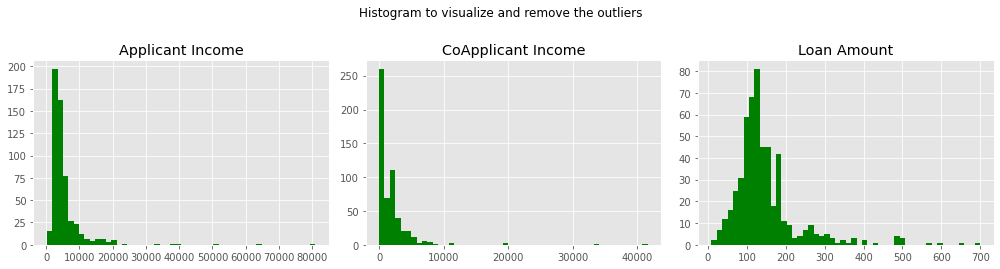

In [699]:
# Histogram to check for outliers or skewed data
plt.figure(figsize=(14,9))
plt.subplot(331)
train_X['ApplicantIncome'].hist(bins=50, color='green')
plt.title('Applicant Income')
plt.tight_layout()
plt.subplot(332)
train_X['CoapplicantIncome'].hist(bins=50, color='green')
plt.title('CoApplicant Income')
plt.subplot(333)
train_X['LoanAmount'].hist(bins=50, color='green')
plt.title('Loan Amount')
plt.tight_layout()
plt.suptitle('Histogram to visualize and remove the outliers', fontsize=12, y=1.04)
plt.show()

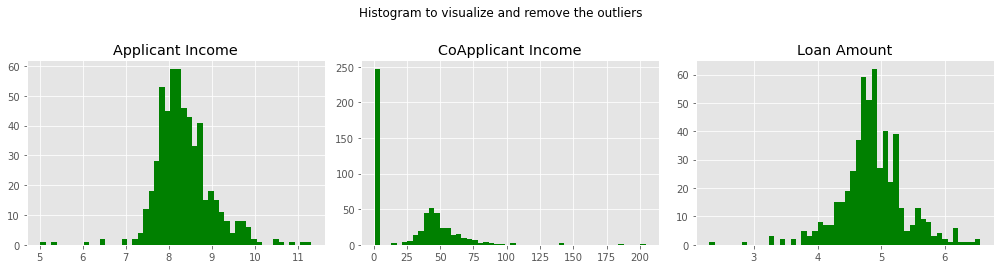

In [700]:
# Apply transformation to the skewed features
train_X['CoapplicantIncome'] = train_X['CoapplicantIncome'].apply(lambda x: np.sqrt(1+x))
train_X['LoanAmount'] = train_X['LoanAmount'].apply(lambda x: np.log(1+x))
train_X['ApplicantIncome'] = train_X['ApplicantIncome'].apply(lambda x: np.log(1+x))

valid_X['CoapplicantIncome'] = valid_X['CoapplicantIncome'].apply(lambda x: np.sqrt(1+x))
valid_X['LoanAmount'] = valid_X['LoanAmount'].apply(lambda x: np.log(1+x))
valid_X['ApplicantIncome'] = valid_X['ApplicantIncome'].apply(lambda x: np.log(1+x))
 
test_X['CoapplicantIncome'] = test_X['CoapplicantIncome'].apply(lambda x: np.sqrt(1+x))
test_X['LoanAmount'] = test_X['LoanAmount'].apply(lambda x: np.log(1+x))
test_X['ApplicantIncome'] = test_X['ApplicantIncome'].apply(lambda x: np.log(1+x))

plt.figure(figsize=(14,9))
plt.subplot(331)
train_X['ApplicantIncome'].hist(bins=50, color='green')
plt.title('Applicant Income')
plt.tight_layout()
plt.subplot(332)
train_X['CoapplicantIncome'].hist(bins=50, color='green')
plt.title('CoApplicant Income')
plt.subplot(333)
train_X['LoanAmount'].hist(bins=50, color='green')
plt.title('Loan Amount')
plt.tight_layout()
plt.suptitle('Histogram to visualize and remove the outliers', fontsize=12, y=1.04)
plt.show()

Int64Index([  5,  27,  41,  60,  66,  76,  81,  88, 116, 145, 147, 159, 179,
            197, 245, 321, 323, 335, 345, 346, 425, 445, 478, 536, 537],
           dtype='int64')
Int64Index([139, 315, 360], dtype='int64')
Int64Index([], dtype='int64')


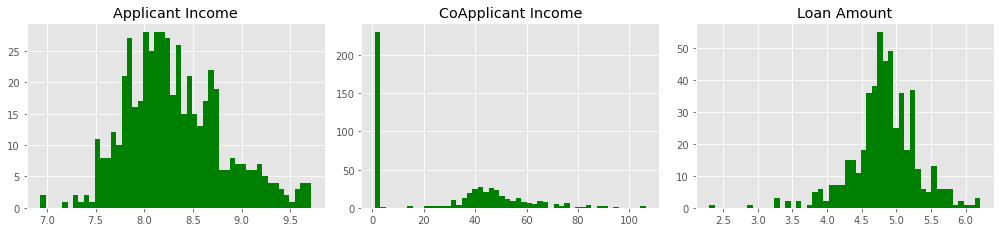

In [701]:
# Reomve the outliers from the train set using interquartile test
for column in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    th1, th2 = np.percentile(train_X[column],[25,75])
    iqr = th2 - th1
    lower_bound = th1 -(1.5 * iqr) 
    upper_bound = th2 +(1.5 * iqr)
    indexes= train_X[(train_X[column] > upper_bound) | (train_X[column] < lower_bound) ].index
    print(indexes)
    train_X.drop(indexes, inplace=True)
    train_X = train_X.reset_index(drop=True)
    for index in sorted(indexes, reverse=True):
      del train_Y[index]

plt.figure(figsize=(14,9))
plt.subplot(331)
train_X['ApplicantIncome'].hist(bins=50, color='green')
plt.title('Applicant Income')
plt.tight_layout()
plt.subplot(332)
train_X['CoapplicantIncome'].hist(bins=50, color='green')
plt.title('CoApplicant Income')
plt.subplot(333)
train_X['LoanAmount'].hist(bins=50, color='green')
plt.title('Loan Amount')
plt.tight_layout()
plt.show()  

In [702]:
"""Fill the missing values"""
# ffill method
# train_X['Loan_Amount_Term'].fillna(method='bfill', inplace=True)
# test_X['Loan_Amount_Term'].fillna(method='bfill', inplace=True)

# train_X['Credit_History'].fillna(method='bfill', inplace=True)
# test_X['Credit_History'].fillna(method='bfill', inplace=True)

# train_X['LoanAmount'].fillna(method='bfill', inplace=True)
# test_X['LoanAmount'].fillna(method='bfill', inplace=True)

# impute with mean, mode or median
for column in ['Self_Employed', 'Loan_Amount_Term',
               'Credit_History', 'Dependents']:
  train_X[column].fillna(train_X[column].mode()[0], inplace=True)
  valid_X[column].fillna(train_X[column].mode()[0], inplace=True)
  test_X[column].fillna(train_X[column].mode()[0], inplace=True)

train_X['LoanAmount'].fillna(train_X['LoanAmount'].median(), inplace=True)
valid_X['LoanAmount'].fillna(train_X['LoanAmount'].median(), inplace=True)
test_X['LoanAmount'].fillna(train_X['LoanAmount'].median(), inplace=True)

In [703]:
# Feature selection based on chi2 and p-values
k = 12
selected_features = SelectKBest(score_func=chi2, k=k)
train_X = selected_features.fit_transform(train_X, train_Y)
test_X = selected_features.transform(test_X)
valid_X = selected_features.transform(valid_X)

In [704]:
# Normalize data
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
valid_X = scaler.transform(valid_X)
test_X = scaler.transform(test_X)
train_Y = np.asarray(train_Y, dtype='float64')
valid_Y = np.asarray(valid_Y, dtype='float64')

In [705]:
print('total number of labels =', train_Y.shape[0])
print('total number of Yes labels =', np.count_nonzero(train_Y))

total number of labels = 524
total number of Yes labels = 363


Epoch 1/1000
1/1 [==============================] - 1s 926ms/step - loss: 0.7154 - accuracy: 0.3397 - f1_m: 0.1762 - val_loss: 0.6514 - val_accuracy: 0.6613 - val_f1_m: 0.7961
Epoch 2/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.6390 - accuracy: 0.6927 - f1_m: 0.8185 - val_loss: 0.6309 - val_accuracy: 0.6613 - val_f1_m: 0.7961
Epoch 3/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.6103 - accuracy: 0.6927 - f1_m: 0.8185 - val_loss: 0.6208 - val_accuracy: 0.6613 - val_f1_m: 0.7961
Epoch 4/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.5935 - accuracy: 0.6927 - f1_m: 0.8185 - val_loss: 0.6146 - val_accuracy: 0.6613 - val_f1_m: 0.7961
Epoch 5/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.5815 - accuracy: 0.6927 - f1_m: 0.8185 - val_loss: 0.6093 - val_accuracy: 0.6613 - val_f1_m: 0.7961
Epoch 6/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.5718 - accuracy: 0.6927 - f1_m: 0.8185 - val_loss

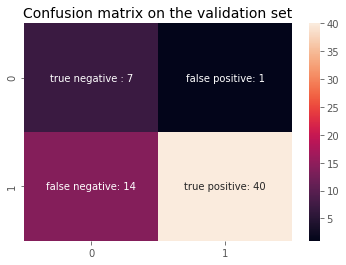

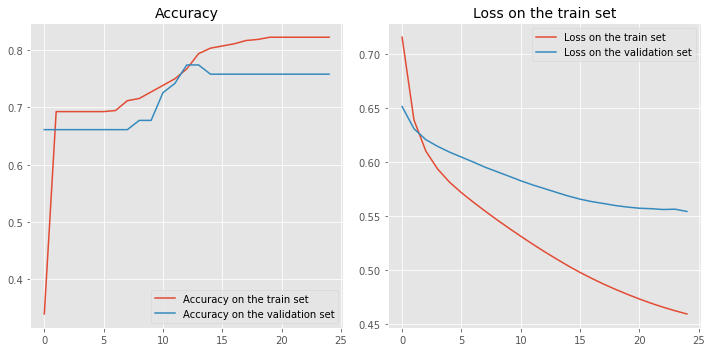

In [706]:
# Build the model
# Since target labels are almost skewed, we use both accuracy and f1 score as metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def build_model():
  # adam = tf.keras.optimizers.Adam(
  #   learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

  inputs = Input(shape=(12,), name='input_layer')
  x = Dense(units=128, activation='relu')(inputs)
  x = Dense(units=64, activation='relu')(x)
  #x = Dense(units=128, activation='relu')(x)
  x = Dense(units=1, name='Output', activation='sigmoid')(x)
  model =  Model(inputs=inputs, outputs=x)

  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy',f1_m])
  history = model.fit(train_X, train_Y, batch_size=1000, validation_data=(valid_X,valid_Y),
                      epochs=1000, verbose=1, callbacks=[callback])
  return [model, history]

# Predict on test set and save the file
[model, history] = build_model()
predictions = model.predict(test_X)
pred = ['Y' if x>=0.5 else 'N' for x in predictions]
pred_dic = list(zip(loan_id, pred))
pred_df = pd.DataFrame(pred_dic, columns=['Loan_ID', 'Loan_Status'])
pred_df.to_csv ('predict.csv', index = False, header=True)

# Confusion matrix on the validation set
valid_pred = model.predict(valid_X)
valid_pred = (valid_pred>0.5)
CM = confusion_matrix(valid_pred, valid_Y)
labels = np.array(['true negative : %i' %CM[0][0] , 'false positive: %i' %CM[0][1],
                  'false negative: %i'%CM[1][0], 'true positive: %i'%CM[1][1]])
labels = labels.reshape((2,2))
sns.heatmap(CM, annot=labels, cmap=None, fmt='');
plt.title('Confusion matrix on the validation set', fontsize=14)
plt.show()

# Accuracy and loss plots
results = history.history
epochs = len(history.history['loss'])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.arange(epochs), results['accuracy'], label='Accuracy on the train set')
plt.plot(np.arange(epochs), results['val_accuracy'], label='Accuracy on the validation set')
plt.title('Accuracy', fontsize=14)
plt.legend()
plt.subplot(122)
plt.plot(np.arange(epochs), results['loss'], label='Loss on the train set')
plt.plot(np.arange(epochs), results['val_loss'], label='Loss on the validation set')
plt.title('Loss on the train set', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()